In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import math

In [ ]:
# Cargar el dataset SVHN
datos, metadatos = tfds.load("svhn_cropped", as_supervised=True, with_info=True)
datos_entrenamiento, datos_pruebas = datos["train"], datos["test"]

nombres_clases = metadatos.features["label"].names


In [ ]:
# Función de normalización
def normalizar(imagenes, etiquetas):
    imagenes = tf.cast(imagenes, tf.float32) / 255.0  # Normalización entre 0 y 1
    return imagenes, etiquetas

datos_entrenamiento = datos_entrenamiento.map(normalizar).cache()
datos_pruebas = datos_pruebas.map(normalizar).cache()

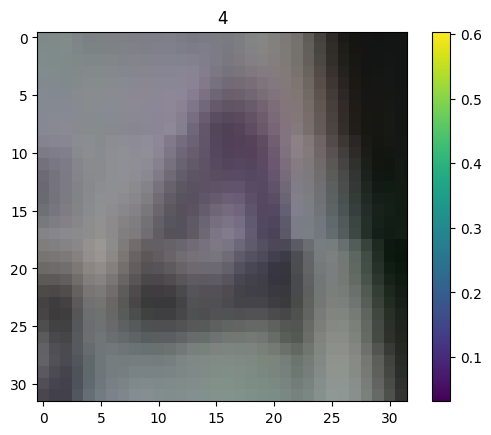

In [ ]:
# Visualizar un ejemplo
for imagen, etiqueta in datos_entrenamiento.take(1):
    break

plt.figure()
plt.imshow(imagen)
plt.colorbar()
plt.title(nombres_clases[etiqueta])
plt.show()

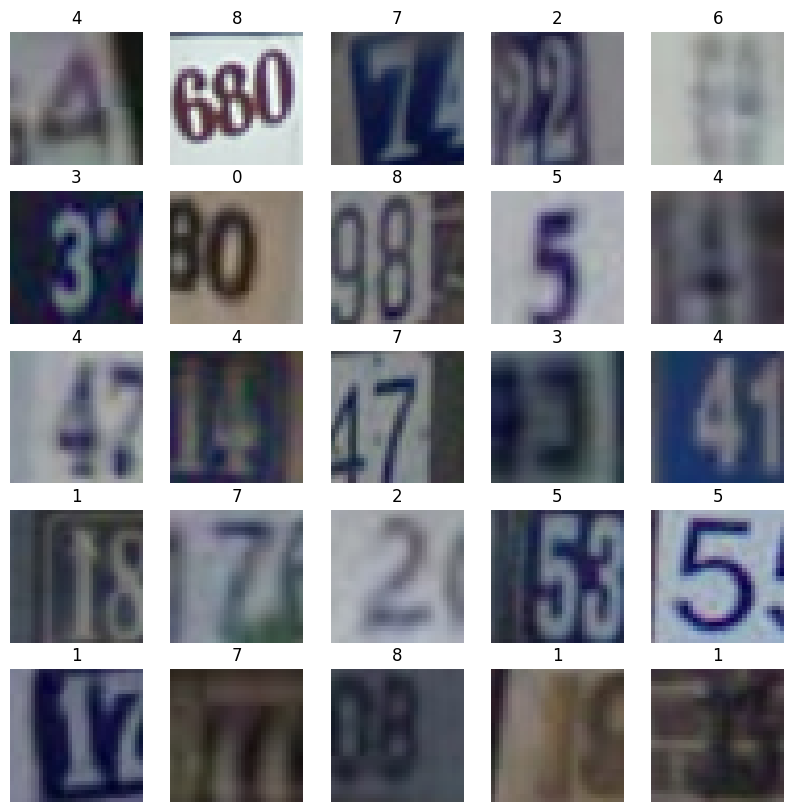

In [ ]:
# Mostrar 25 imágenes de entrenamiento
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
    plt.subplot(5, 5, i+1)
    plt.imshow(imagen)
    plt.axis('off')
    plt.title(nombres_clases[etiqueta])
plt.show()

In [ ]:
# Crear modelo CNN
modelo = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), input_shape=(32, 32, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [ ]:
# Compilar el modelo
modelo.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

In [ ]:
# Preparar datos por lotes
TAMANO_LOTE = 32
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(73257).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [ ]:
# Entrenar el modelo
modelo.fit(
    datos_entrenamiento, epochs=15,
    steps_per_epoch=math.ceil(73257 / TAMANO_LOTE)
)


Epoch 1/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 105s 46ms/step - accuracy: 0.8080 - loss: 0.6629
Epoch 2/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 105s 46ms/step - accuracy: 0.8798 - loss: 0.4139
Epoch 3/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 101s 44ms/step - accuracy: 0.8996 - loss: 0.3428
Epoch 4/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 100s 44ms/step - accuracy: 0.9130 - loss: 0.3023
Epoch 5/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 99s 43ms/step - accuracy: 0.9211 - loss: 0.2702
Epoch 6/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 101s 44ms/step - accuracy: 0.9270 - loss: 0.2461
Epoch 7/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 100s 44ms/step - accuracy: 0.9330 - loss: 0.2244
Epoch 8/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 104s 45ms/step - accuracy: 0.9403 - loss: 0.2058
Epoch 9/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 99s 43ms/step - accuracy: 0.9448 - loss: 0.1854
Epoch 10/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 101s 44ms/step - accuracy: 0.9477 - loss: 0.1759
Epoch 11/15
2290/2290 ━━━━━━━━━━━━━━━━━━━━ 102s 45ms/step - accuracy: 0.9500 - loss: 0.1629

In [ ]:
# Evaluar y mostrar predicciones
for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
    imagenes_prueba = imagenes_prueba.numpy()
    etiquetas_prueba = etiquetas_prueba.numpy()
    etiquetas_prueba = np.where(etiquetas_prueba == 10, 0, etiquetas_prueba)  # Ajustar etiqueta 10 a 0
    predicciones = modelo.predict(imagenes_prueba)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step


In [ ]:
# Asegurarse de que los nombres de las clases estén bien definidos
nombres_clases = [str(i) for i in range(10)]

# Función para graficar la imagen con su predicción
def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
    arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img)
    etiqueta_prediccion = np.argmax(arr_predicciones)
    color = "blue" if etiqueta_prediccion == etiqueta_real else "red"
    plt.xlabel("{} {:2.0f}% (real: {})".format(
        nombres_clases[etiqueta_prediccion],
        100*np.max(arr_predicciones),
        nombres_clases[etiqueta_real]),
        color=color)

In [ ]:
# Función para graficar la barra de confianza
def graficar_valor_arreglo(i, arr_predicciones, etiquetas_reales):
    arr_predicciones, etiqueta_real = arr_predicciones[i], etiquetas_reales[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    grafica = plt.bar(range(10), arr_predicciones, color="#777777")
    plt.ylim([0, 1])
    prediccion = np.argmax(arr_predicciones)
    grafica[prediccion].set_color('red')
    grafica[etiqueta_real].set_color('blue')


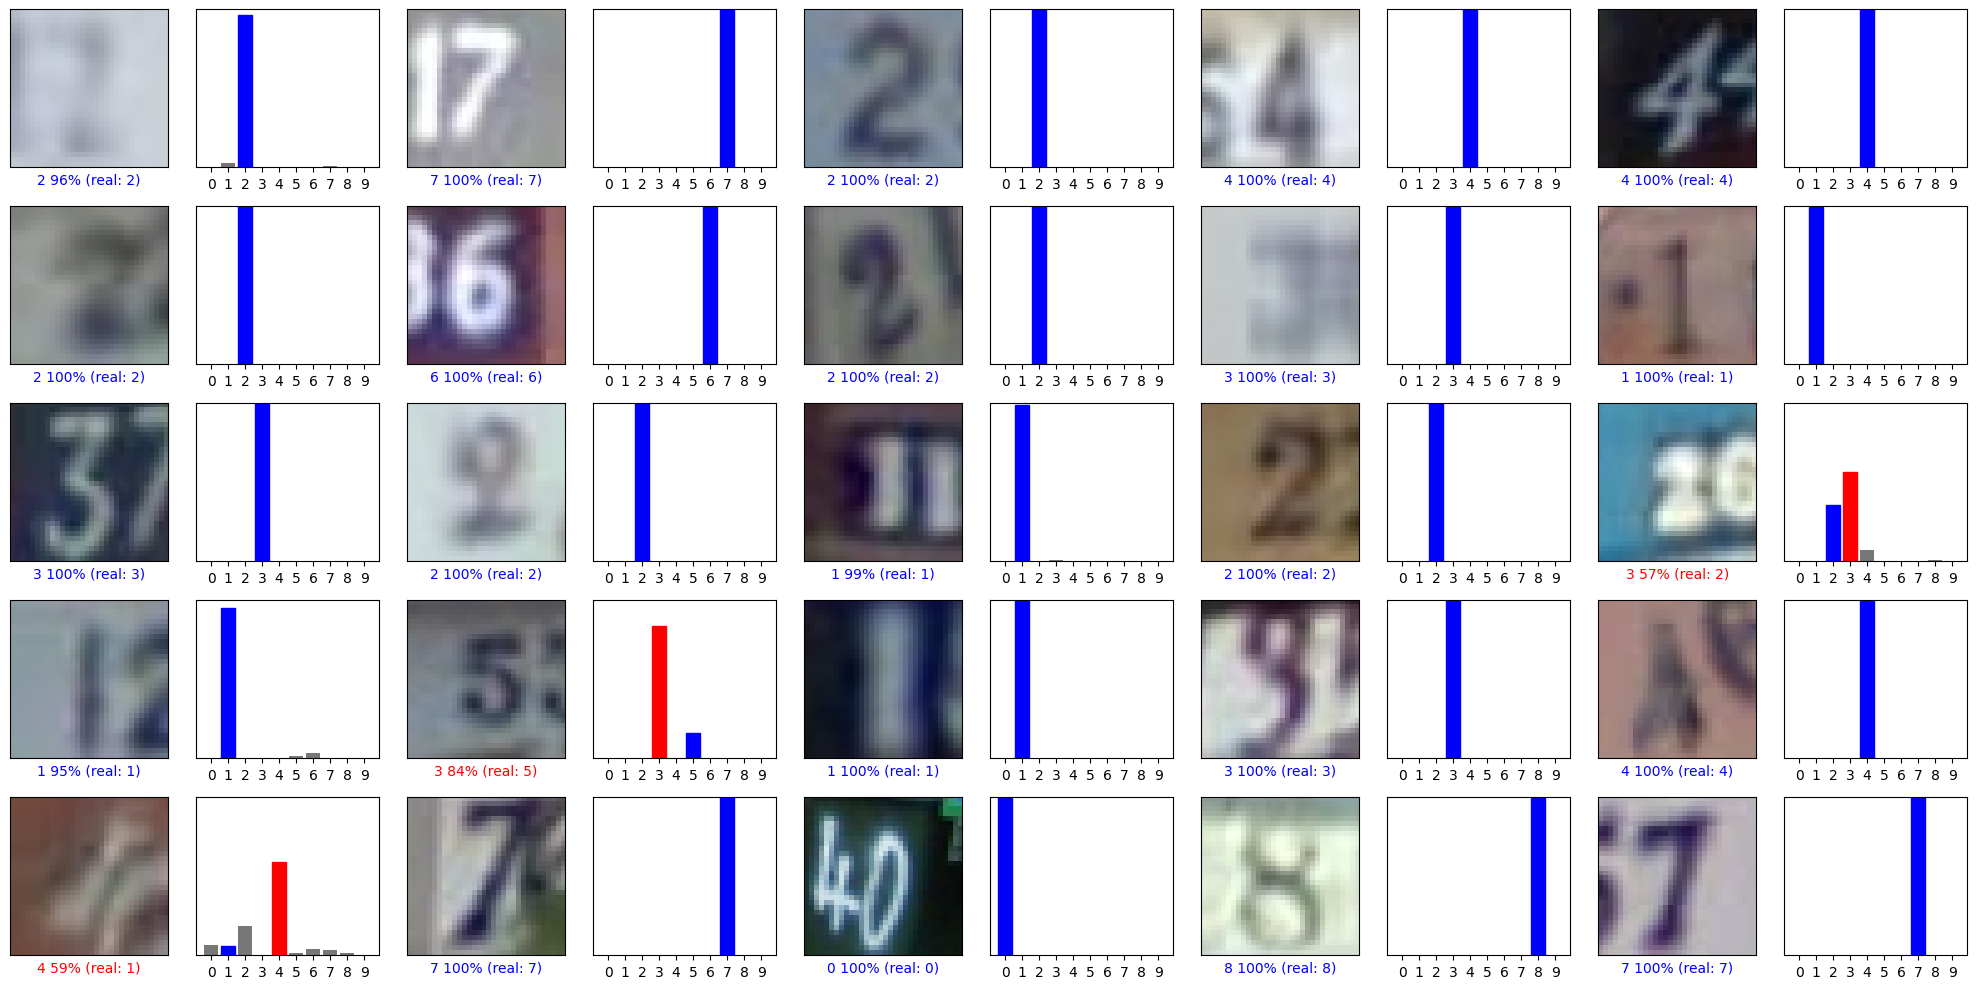

In [ ]:
# Mostrar 25 imágenes con sus predicciones
filas = 5
columnas = 5
num_imagenes = filas * columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
    plt.subplot(filas, 2*columnas, 2*i+1)
    graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
    plt.subplot(filas, 2*columnas, 2*i+2)
    graficar_valor_arreglo(i, predicciones, etiquetas_prueba)
plt.tight_layout()
plt.show()